<a href="https://colab.research.google.com/github/cascon81/biomaterial-analyser/blob/main/Modelo_Printabilidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os

# 1) Leitura de paths e labels
image_paths, labels = [], []
with open("/content/labels.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        image_paths.append(os.path.join("/content", parts[0]))
        labels.append([float(parts[1].replace(",", ".")),
                       float(parts[2].replace(",", "."))])
labels = tf.constant(labels, dtype=tf.float32)

# 2) Loader 100% grayscale com augmentações de luminosidade/contraste
def load_image_gray(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    # converte para grayscale e volta para 3 canais (canais idênticos)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)

    # augmentações úteis mesmo em grayscale
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return tf.cast(img, tf.float32) / 255.0

# 3) Split treino/val
split = int(0.8 * len(image_paths))
train_paths, val_paths = image_paths[:split], image_paths[split:]
train_labels, val_labels = labels[:split], labels[split:]

# 4) Pipelines
def make_ds(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, l: (load_image_gray(p), l),
                num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_paths, train_labels, shuffle=True)
val_ds   = make_ds(val_paths,   val_labels,   shuffle=False)

# 5) Mesma arquitetura leve de antes
model = tf.keras.Sequential([
    tf.keras.layers.Input((128, 128, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 6) Scheduler suave, como você já ajustou
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=6,
    cooldown=4,
    min_lr=1e-6,
    verbose=1
)

# 7) Treino
history = model.fit(
    train_ds,
    epochs=80,
    validation_data=val_ds,
    callbacks=[reduce_lr]
)

# 8) Salva
model.save("/content/Printabilidade_geral.keras")
print("✅ Treino completo, modelo salvo!")


Epoch 1/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8126 - mae: 0.7981 - val_loss: 34.1267 - val_mae: 5.1751 - learning_rate: 0.0010
Epoch 2/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 36.4271 - mae: 5.3113 - val_loss: 0.0351 - val_mae: 0.1403 - learning_rate: 0.0010
Epoch 3/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.1135 - mae: 0.2662 - val_loss: 1.7728 - val_mae: 1.1670 - learning_rate: 0.0010
Epoch 4/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 1.9727 - mae: 1.2272 - val_loss: 1.2862 - val_mae: 1.0275 - learning_rate: 0.0010
Epoch 5/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 1.4806 - mae: 1.0956 - val_loss: 1.0054 - val_mae: 0.9138 - learning_rate: 0.0010
Epoch 6/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step - loss: 1.1491 - mae: 0.9635 - val_loss: 0.7965 - val_mae: 0.8115 - learning_rate: 0.0010
Epoch 7/80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.9209 - mae: 0.8548 - val_loss: 0.5905 - val_mae: 0.6980 - learning_rate: 0.0010
Epoch 8/80
1/1 ━━━━━━

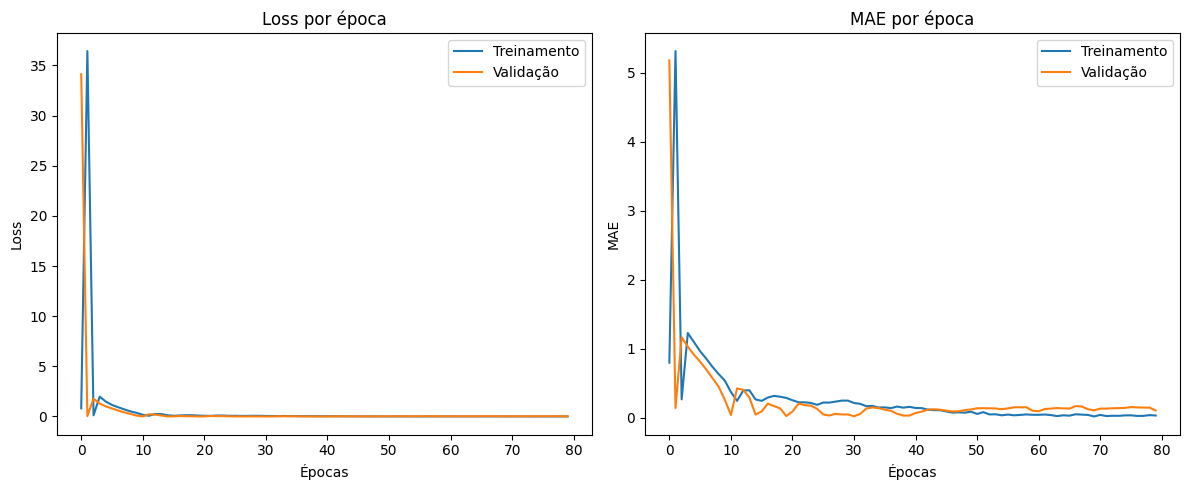

In [3]:
import matplotlib.pyplot as plt

# Plot das curvas de perda (loss) e MAE
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss por época')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Treinamento')
plt.plot(history.history['val_mae'], label='Validação')
plt.title('MAE por época')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
